In [40]:
import rasterio as rio
import rasterio.mask as rio_mask

import geopandas as gpd

import shapely
import ee
import geemap
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from pathlib import Path
import os
import numpy as np
import pandas as pd

In [67]:
SMOD_COLOR_MAP = {
    "Rural": "#3CB371",
    "Zona urbana": "#FFA500",
    "Centro urbano": "#CD5C5C",
}

In [41]:
ee.Initialize(project="ee-ursa-test")

In [42]:
data_path = Path(os.environ["DATA_PATH"])
ghsl_path = Path(os.environ["GHSL_PATH"])
figure_path = Path("./fig")

In [43]:
df_bounds = gpd.read_file(data_path / "area_de_estudio" / "d_160101_ambito_estudio.shp")
crs = df_bounds.estimate_utm_crs()
df_bounds = df_bounds.to_crs(crs)

In [44]:
bounds = df_bounds.to_crs("ESRI:54009")["geometry"].item()

In [45]:
bounds_latlon = (
    df_bounds
    .assign(geometry=lambda df: df["geometry"].simplify(100))
    .to_crs("EPSG:4326")
    ["geometry"]
    .item()
)

bounds_ee = ee.geometry.Geometry.Polygon(list(bounds_latlon.exterior.coords))

# Population

In [68]:
rows = []
for year in range(1975, 2021, 5):
    with rio.open(ghsl_path / "POP_1000" / f"{year}.tif", nodata=0) as ds_pop, rio.open(ghsl_path / "SMOD_1000" / f"{year}.tif", nodata=-200) as ds_smod:
        pop, _ = rio_mask.mask(ds_pop, [bounds], crop=True, nodata=0)
        smod, _ = rio_mask.mask(ds_smod, [bounds], crop=True, nodata=-200)

        pop = pop.squeeze()
        
        smod = smod.squeeze()
        smod[smod == -200] = 0
        smod = smod // 10

    count = np.bincount(smod.flatten(), weights=pop.flatten())
    for smod_val in range(4):
        try:
            dpop = count[smod_val]
        except IndexError:
            dpop = 0
        rows.append({
            "year": year,
            "smod": smod_val,
            "pop": dpop
        })

df_pop = (
    pd.DataFrame(rows)
    .query("smod != 0")
    .pivot_table(index="year", columns="smod", values="pop", fill_value=0)
    .rename(columns={1: "Rural", 2: "Zona urbana", 3: "Centro urbano"})
)

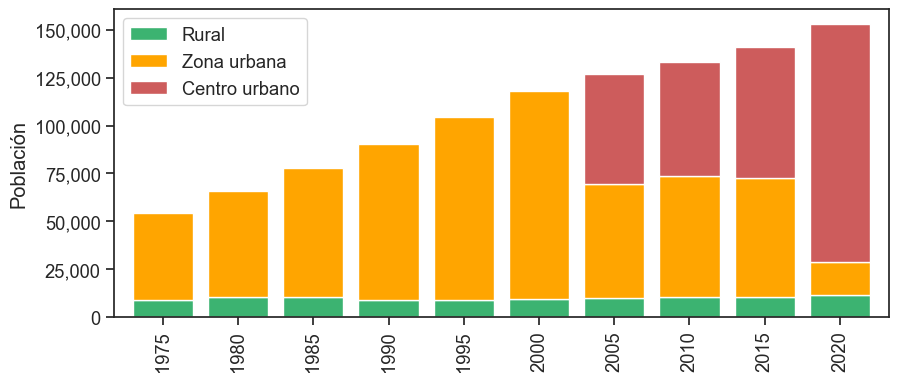

In [72]:
sns.set_theme(style="ticks", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 4))
df_pop.plot.bar(stacked=True, width=0.8, ax=ax, color=SMOD_COLOR_MAP)
ax.set_xlabel("")
ax.set_ylabel("Población")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.legend(title=None)
fig.savefig(figure_path / "pop.jpg", bbox_inches="tight", dpi=300)

# Built

## Area

In [48]:
built_areas = []
built_arr = []

for year in range(1975, 2021, 5):
    with rio.open(ghsl_path / "BUILT_100" / f"{year}.tif", nodata=0) as ds:
        profile = ds.profile
        built, transform = rio_mask.mask(ds, [bounds], crop=True, nodata=0)
        built = built.squeeze()

    built_areas.append({
        "year": year,
        "area": built.astype(float).sum()
    })

    mask = (built >= (0.2 * 100 * 100)) * year
    built_arr.append(mask)

df_area = pd.DataFrame(built_areas, columns=["year", "area"]).set_index("year").divide(1e6)

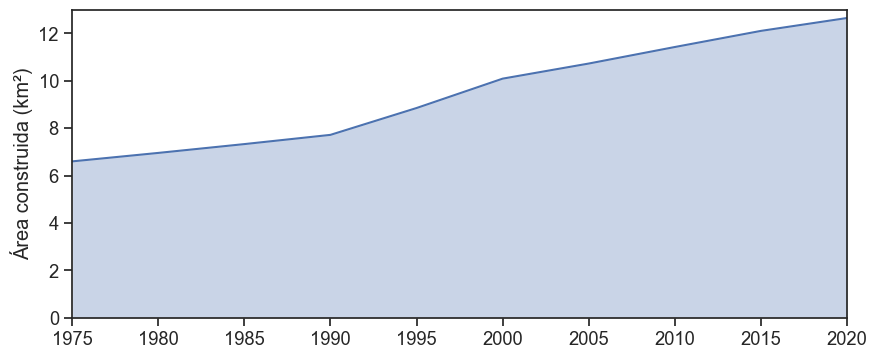

In [49]:
sns.set_theme(font_scale=1.2, style="ticks")

fig, ax = plt.subplots(figsize=(10, 4))
df_area.plot(ax=ax, legend=False)
ax.fill_between(df_area.index, df_area["area"], alpha=0.3)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

ax.set_xlabel("")
ax.set_ylabel("Área construida (km²)")

ax.set_xlim(1975, 2020)
ax.set_ylim(0, 13)
fig.savefig(figure_path / "built_area.jpg", bbox_inches="tight", dpi=300)

In [56]:
df_area

,area
year,
1975,6.601461
1980,6.959104
1985,7.331708
1990,7.721220
1995,8.854208
2000,10.094263
2005,10.731772
2010,11.429577
2015,12.110137


## Year

In [50]:
built_arr = np.array(built_arr).astype(float)
built_arr[built_arr == 0] = np.nan
built_arr = np.nanmin(built_arr, axis=0)
built_arr[np.isnan(built_arr)] = 0
built_arr = built_arr.astype(np.uint16)

C:\Users\lain\AppData\Local\Temp\ipykernel_29684\3285329835.py:3: RuntimeWarning: All-NaN slice encountered
  built_arr = np.nanmin(built_arr, axis=0)


In [ ]:
with rio.open(
    "./built_year.tif", 
    "w", 
    height=built_arr.shape[0],
    width=built_arr.shape[1],
    count=1,
    dtype="uint16",
    crs="ESRI:54009",
    transform=transform,
    compress="lzw",
    nodata=0,
) as ds:
    ds.write(built_arr, 1)

CPLE_AppDefinedError: Deleting ./built_year.tif failed: Permission denied

# Land cover

In [53]:
land_cover_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]

In [54]:
rows = []
for year in range(2016, 2025):
    img = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filterBounds(bounds_ee)
        .filterDate(f"{year}-01-01", f"{year}-12-31")
        .select("label")
        .mode()
        .clip(bounds_ee)
    )

    img_area = ee.image.Image.pixelArea().addBands(img)

    reduced = img_area.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName="label"),
        geometry=bounds_ee,
        scale=30,
        maxPixels=1e9
    ).getInfo()

    groups = reduced["groups"]
    for group in groups:
        group["year"] = year

    rows.extend(groups)

df_land_cover = (
    pd.DataFrame(rows)
    .assign(label=lambda df: df["label"].map({i: land_cover_labels[i] for i in range(len(land_cover_labels))}))
    .pivot_table(index="year", columns="label", values="sum", fill_value=0)
)

<Axes: xlabel='year'>

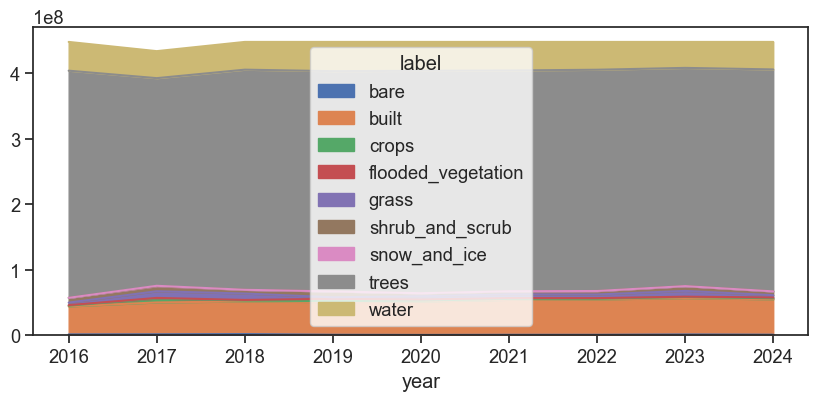

In [55]:
sns.set_theme(font_scale=1.2, style="ticks")

fig, ax = plt.subplots(figsize=(10, 4))
df_land_cover.plot.area(ax=ax)

In [88]:
m = geemap.Map(center=[-3.75, -73.25], zoom=10, height=800)
m.addLayer(img)
m

Map(center=[-3.75, -73.25], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…

<IPython.core.display.Javascript object>